### Background
We plan to verify A.9 ATTENTION PATTERNS. Specifically, the DeBERTa [paper](https://arxiv.org/abs/2006.03654) mentions the following:

"We observe vertical strips in the attention patterns of RoBERTa, which are mainly caused by high-frequent functional words or tokens (e.g., “a”, “the”, and punctuation). For DeBERTa, the strip only appears in the first column, which represents the [CLS] token. We conjecture that a dominant emphasis on [CLS] is desirable since the feature vector of [CLS] is often used as a contextual representation of the entire input sequence in downstream tasks. Wealso observe that the vertical strip effect is quite obvious in the patterns of the three DeBERTa variants."

All the evidence for the above are **3** **qualitative** examples. Can we answer more **quantitatively** :


*   Does RoBERTa have strips any more than DeBERTa ?
*   Are DeBERTa strips only in the [CLS] position ?
*   Is the cause of RoBERTa strips due to function words ?

Bonus (Not attempted here): 

*   Is it desirable to have the strips only for the [CLS] token ?



In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load Models

In [ ]:
import os
import re
import sys
import random
import string
import math
import time
import pickle
import ast
import collections as C
import copy
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.utils import shuffle
from sklearn.model_selection import *
from sklearn.metrics import *
from matplotlib import pyplot as plt
from ast import literal_eval
import transformers
import seaborn as sns
from transformers import *
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation,concatenate,Embedding,LSTM,Conv1D,MaxPooling1D,Flatten,Input,Bidirectional, Input
from tensorflow.keras.layers import Subtract,Lambda,Add,Conv1D,Reshape,Dropout,Permute
from transformers import BertTokenizer, TFBertForSequenceClassification,TFBertModel, TFDistilBertModel, DistilBertTokenizer, TFAlbertModel , AlbertTokenizer
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model,to_categorical
from transformers import DebertaTokenizer, TFDebertaModel, RobertaTokenizer, TFRobertaModel,BertTokenizer, TFBertModel

In [ ]:
debertatokenizer = DebertaTokenizer.from_pretrained("kamalkraj/deberta-base")
debertamodel = TFDebertaModel.from_pretrained("kamalkraj/deberta-base",output_attentions=True)
debertamodel.summary()

loading file https://huggingface.co/kamalkraj/deberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/ad017f49b895d846dc42892b51bdda3cd43f9ef86ca8e2687812c5ef9fa7f5a2.e8ad27cc324bb0dc448d4d95f63e48f72688fb318a4c4c3f623485621b0b515c
loading file https://huggingface.co/kamalkraj/deberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/8a213ef7f7e5710ea31384b0c6b388408fefe006242d3219cacc7ff14e759da6.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/kamalkraj/deberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/kamalkraj/deberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/kamalkraj/deberta-base/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/840cabfd8b3a5398a78d476cf51ceceedcc5cdb3f7a0d61743379fe579dcd149.a39abb1c6179fb264c2db685f9a056b7cb8

Model: "tf_deberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deberta (TFDebertaMainLayer  multiple                 138601728 
 )                                                               
                                                                 
Total params: 138,601,728
Trainable params: 138,601,728
Non-trainable params: 0
_________________________________________________________________


In [ ]:
robertatokenizer = RobertaTokenizer.from_pretrained("roberta-base")
robertamodel = TFRobertaModel.from_pretrained("roberta-base",output_attentions=True)
robertamodel.summary()

loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124645632 
 )                                                               
                                                                 
Total params: 124,645,632
Trainable params: 124,645,632
Non-trainable params: 0
_________________________________________________________________


In [ ]:
berttokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bertmodel = TFBertModel.from_pretrained("bert-base-uncased",output_attentions=True)
bertmodel.summary()

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#batch_size, num_heads, sequence_length, sequence_length

In [ ]:
"""path= "bert-base-uncased"
T=450
def create_model():
  In=Input(shape=(T),name="Input_Sentence",dtype=np.int64)
  o=bertmodel(In)
  o = Dense(3)(o[0][:,0,:])#[0][0])
  o =  Activation("softmax",name="start")(o)
  model_o=Model(inputs=In,outputs=o)
  return model_o
model_o = create_model()
model_o.summary()"""

'path= "bert-base-uncased"\nT=450\ndef create_model():\n  In=Input(shape=(T),name="Input_Sentence",dtype=np.int64)\n  o=bertmodel(In)\n  o = Dense(3)(o[0][:,0,:])#[0][0])\n  o =  Activation("softmax",name="start")(o)\n  model_o=Model(inputs=In,outputs=o)\n  return model_o\nmodel_o = create_model()\nmodel_o.summary()'

In [ ]:
inputs = robertatokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = robertamodel(inputs)

last_hidden_states = outputs.last_hidden_state
np.array(outputs.attentions).shape

#inputs = berttokenizer("Hello, my dog is cute", return_tensors="tf")
#outputs = bertmodel(inputs)

(12, 1, 12, 8, 8)

### Dataset

In [ ]:
!wget https://github.com/harvardnlp/sent-conv-torch/raw/master/data/stsa.fine.dev
!wget https://raw.githubusercontent.com/harvardnlp/sent-conv-torch/master/data/stsa.fine.phrases.train
!wget https://github.com/harvardnlp/sent-conv-torch/raw/master/data/stsa.fine.train
!wget https://github.com/harvardnlp/sent-conv-torch/raw/master/data/stsa.fine.test

DPATH="./"
train=open(DPATH+"stsa.fine.train","r",encoding="ISO-8859-1").readlines()
test=open(DPATH+"stsa.fine.test","r",encoding="ISO-8859-1").readlines()
dev=open(DPATH+"stsa.fine.dev","r",encoding="ISO-8859-1").readlines()
phras=open(DPATH+"stsa.fine.phrases.train","r",encoding="ISO-8859-1").readlines()
train=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in train]
test=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in test]
dev=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in dev]
phras=[[int(i[0]),re.split(r'\d\s',i)[1].strip()] for i in phras]
trainlabels,traindata=list(zip(*train))
testlabels,testdata=list(zip(*test))
devlabels,devdata=list(zip(*dev))

train_sentences = traindata
test_sentences = testdata
dev_sentences = devdata

sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
max_sentence_length = max(sentence_lengths)
print("Maximum Sentence Length: {} ".format(max_sentence_length))
train_sentence = train_sentences
dev_sentence = dev_sentences
print("Training Data Size: {} ".format(len(train_sentence)))
print("Validation Data Size: {} ".format(len(dev_sentence)))

--2022-09-12 10:37:50--  https://github.com/harvardnlp/sent-conv-torch/raw/master/data/stsa.fine.dev
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/harvardnlp/sent-conv-torch/master/data/stsa.fine.dev [following]
--2022-09-12 10:37:50--  https://raw.githubusercontent.com/harvardnlp/sent-conv-torch/master/data/stsa.fine.dev
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117239 (114K) [text/plain]
Saving to: ‘stsa.fine.dev.3’

stsa.fine.dev.3     100%[===================>] 114.49K  --.-KB/s    in 0.01s   

2022-09-12 10:37:50 (8.51 MB/s) - ‘stsa.fine.dev.3’ saved [117239/117239]

--2022-09-1

In [ ]:
max_num = 1000

### Tokenization & Prediction

In [ ]:
bertinputs = berttokenizer(train_sentence[:max_num],return_tensors='tf',max_length=50,padding="max_length",add_special_tokens=True, truncation=True)
bertoutputs = bertmodel(bertinputs)# 3 minutes for 1000

In [ ]:
robertainputs = robertatokenizer(train_sentence[:max_num],return_tensors='tf',max_length=50,padding="max_length",add_special_tokens=True, truncation=True)
robertaoutputs = robertamodel(robertainputs)

In [ ]:
debertainputs = debertatokenizer(train_sentence[:max_num],return_tensors='tf',max_length=50,padding="max_length",add_special_tokens=True, truncation=True)
debertaoutputs = debertamodel(debertainputs)

In [ ]:
bertattentions = np.array(bertoutputs.attentions)
robertaattentions = np.array(robertaoutputs.attentions) 
debertaattentions = np.array(debertaoutputs.attentions)
bertattentions.shape, robertaattentions.shape, debertaattentions.shape

((12, 1000, 12, 50, 50), (12, 1000, 12, 50, 50), (12, 1000, 12, 50, 50))

LAYERS x SAMPLES x HEADS x T x T

### Visualizations

What the paper mentions regarding the attention visualizations:


1.   They are from the last layer

What we assume:

1. They are from the last layer
2. The Models are Base (RoBERTa and DeBERTa)
3. Visualizations are averaged across heads (12 in base)
4. The Models are NOT fine-tuned
5. Sentences can be from a task such as SST (part of GLUE)
6. Visualizations INCLUDE special tokens

In [ ]:
sampleid= 3
def condensed_attention(sampleid,attention_matrix):
  return np.mean(attention_matrix[-1][sampleid],axis=0)

In [ ]:
def visualize_sentence(sentence,aspect,truelabel,modelpair,hide_pad=False):
  model,attenmodel=modelpair
  a,b,c,d = tokenize_sentences([sentence],[aspect],T)
  print(" ".join(d[0][:-d[0].count("[PAD]")]))
  print("Prediction:",np.argmax(model.predict([a,b,c])[0])==truelabel)
  attentions = np.array(attenmodel.predict([a,b,c]))
  print(attentions.shape)
  attentions = attentions.reshape(12,12,T,T)
  attentions = attentions.reshape(144,T,T)
  attentions = np.mean(attentions,axis=0)
  if hide_pad==False:
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(attentions,xticklabels=d[0],yticklabels=d[0])
    plt.show()
  if hide_pad==True:
    num_pads = d[0].count("[PAD]")
    fig, ax = plt.subplots(figsize=((T-num_pads)/4,(T-num_pads-2)/4))
    sns.heatmap(attentions[:-num_pads,:-num_pads],xticklabels=d[0][:-num_pads],yticklabels=d[0][:-num_pads],cmap=random.choice(colors))
    plt.show()
   

In [ ]:
sample_id = 3

#### Qualitative Analysis

In [ ]:
fig_size= (9,8)
def bert(sample_id,hide_pad = False):
  if hide_pad == True:
    fig, ax = plt.subplots(figsize=fig_size)
    sentence=berttokenizer.convert_ids_to_tokens(bertinputs["input_ids"][sample_id])
    num_pads = sentence.count("[PAD]")
    sns.heatmap(condensed_attention(sample_id,bertattentions)[:-num_pads,:-num_pads],xticklabels=sentence[:-num_pads],yticklabels=sentence[:-num_pads])
    plt.show()
  else:
    fig, ax = plt.subplots(figsize=fig_size)
    sentence=berttokenizer.convert_ids_to_tokens(bertinputs["input_ids"][sample_id])
    sns.heatmap(condensed_attention(sample_id,bertattentions),xticklabels=sentence,yticklabels=sentence)
    plt.show()
def roberta(sample_id,hide_pad = False):
  if hide_pad == True:
    fig, ax = plt.subplots(figsize=fig_size)
    sentence=robertatokenizer.convert_ids_to_tokens(robertainputs["input_ids"][sample_id])
    num_pads = sentence.count("<pad>")
    sns.heatmap(condensed_attention(sample_id,robertaattentions)[:-num_pads,:-num_pads],xticklabels=sentence[:-num_pads],yticklabels=sentence[:-num_pads])
    plt.show()
  else:
    fig, ax = plt.subplots(figsize=fig_size)
    sentence=robertatokenizer.convert_ids_to_tokens(robertainputs["input_ids"][sample_id])
    sns.heatmap(condensed_attention(sample_id,robertaattentions),xticklabels=sentence,yticklabels=sentence)
    plt.show()

def deberta(sample_id,hide_pad =False):
  if hide_pad == True:
    fig, ax = plt.subplots(figsize=fig_size)
    sentence=debertatokenizer.convert_ids_to_tokens(debertainputs["input_ids"][sample_id])
    num_pads = sentence.count("[PAD]")
    sns.heatmap(condensed_attention(sample_id,debertaattentions)[:-num_pads,:-num_pads],xticklabels=sentence[:-num_pads],yticklabels=sentence[:-num_pads])
    plt.show()
  else:
    fig, ax = plt.subplots(figsize=fig_size)
    sentence=debertatokenizer.convert_ids_to_tokens(debertainputs["input_ids"][sample_id])
    sns.heatmap(condensed_attention(sample_id,debertaattentions),xticklabels=sentence,yticklabels=sentence)
    plt.show()

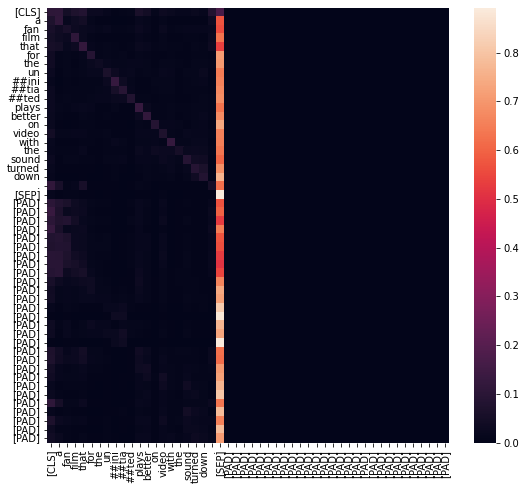

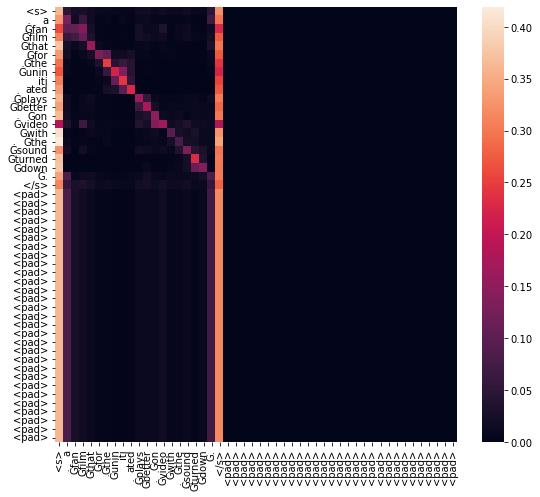

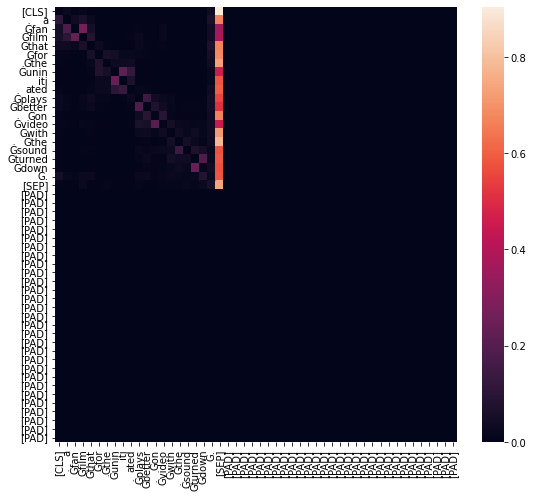

In [ ]:
bert(8)
roberta(8)
deberta(8)

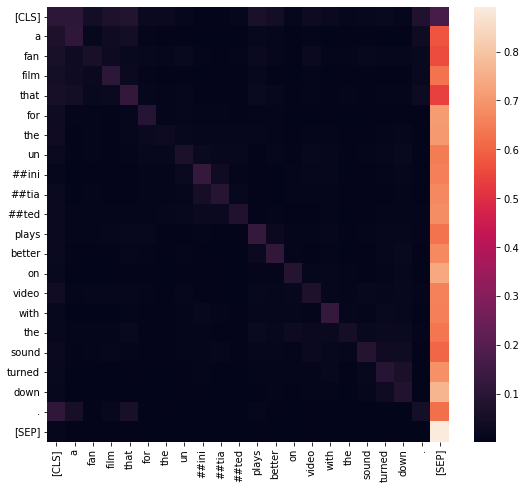

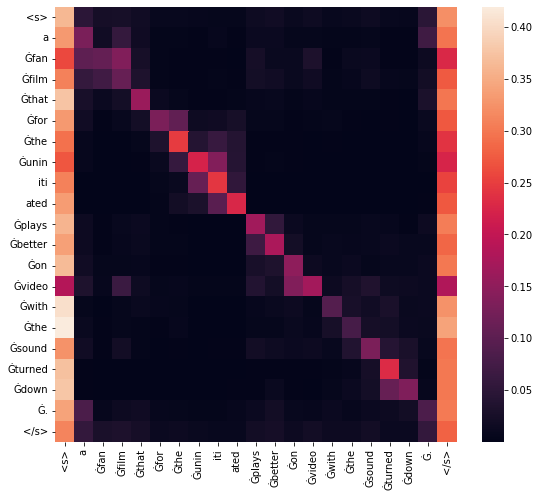

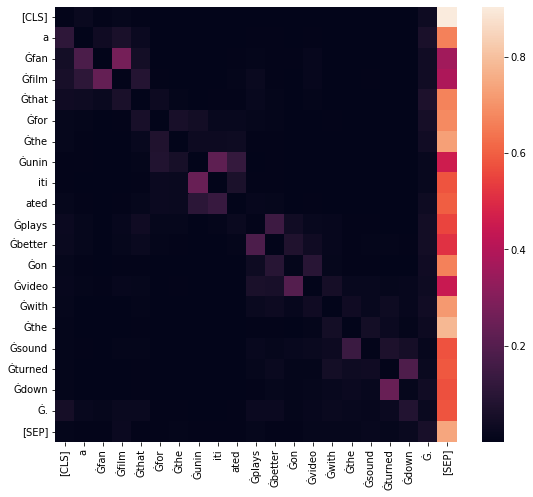

In [ ]:
bert(8,True)
roberta(8,True)
deberta(8,True)

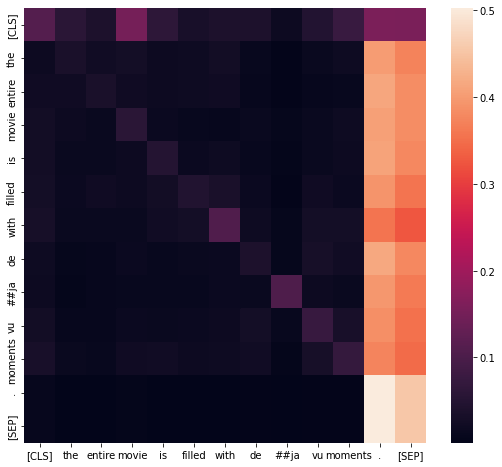

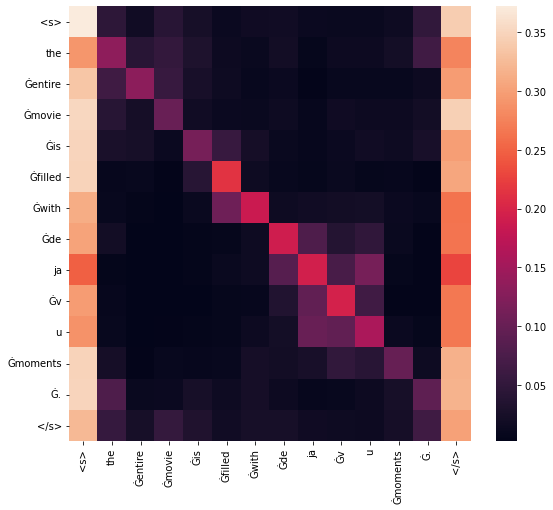

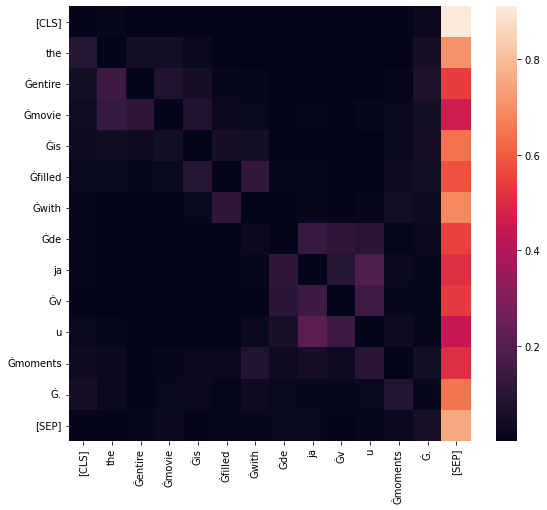

In [ ]:
bert(3,True)
roberta(3,True)
deberta(3,True)

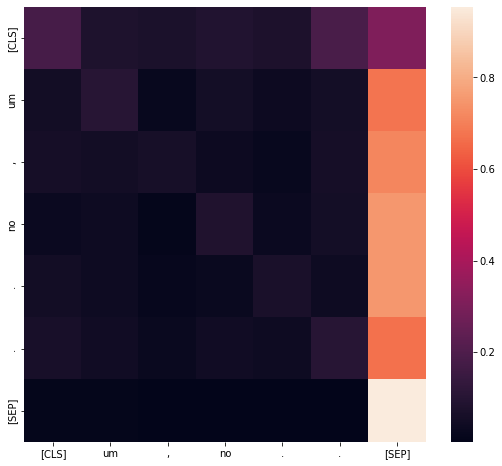

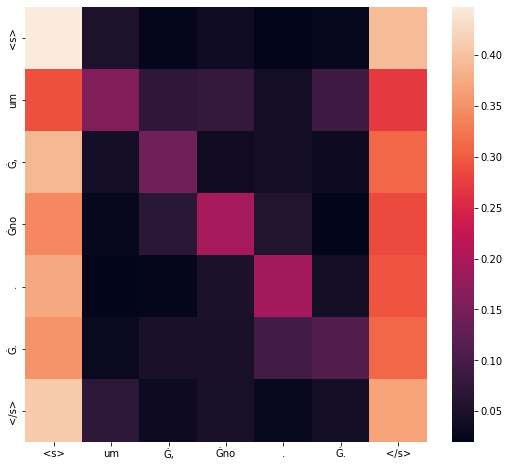

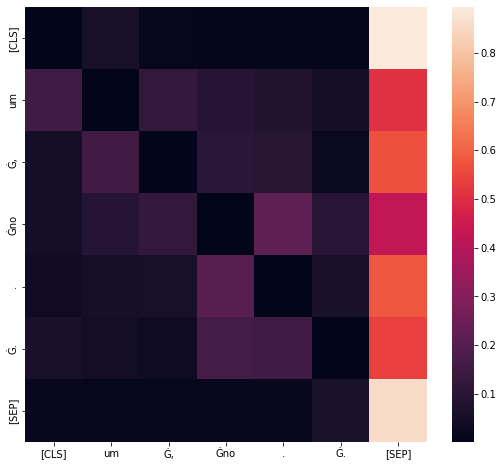

In [ ]:
bert(5,True)
roberta(5,True)
deberta(5,True)

#### Quantitative Analysis

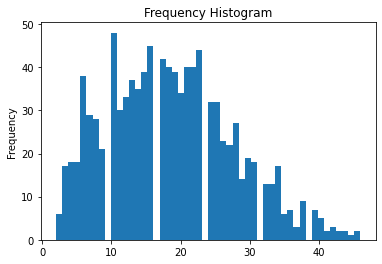

In [233]:
import itertools
x = [len(i.split()) for i in train_sentences[:max_num]]
plt.hist(x, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

##### BERT

[20]


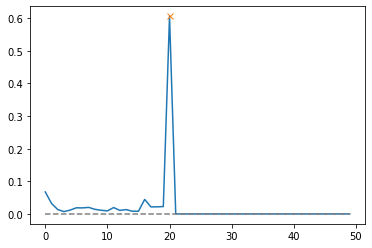

[17]


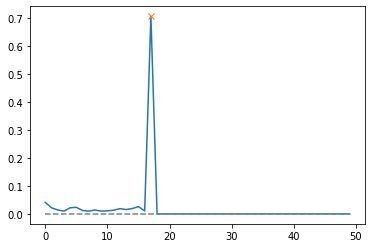

[16 21 46]


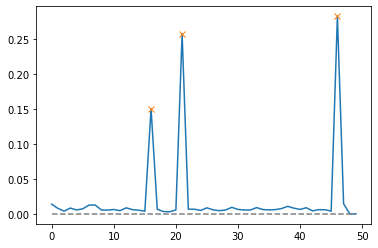

[11]


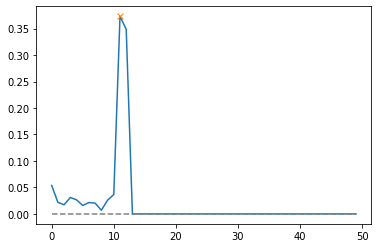

[21]


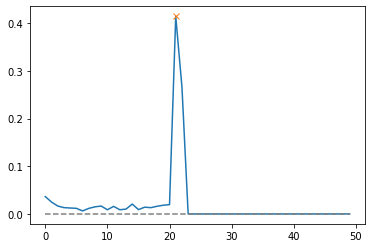

[6]


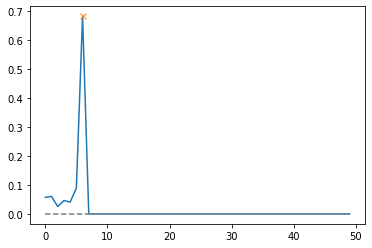

[29]


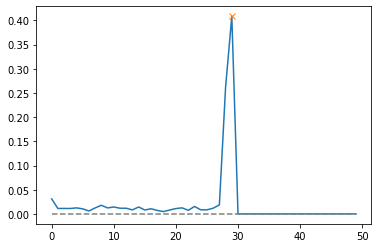

[23]


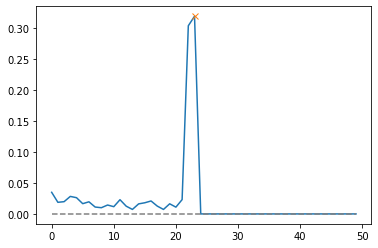

[21]


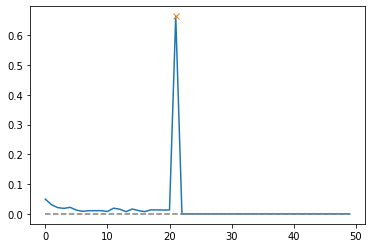

[10 20]


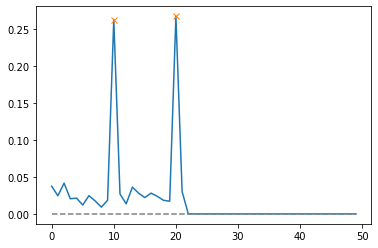

In [ ]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
for i in np.arange(10):
  x = np.mean(condensed_attention(i,bertattentions),axis=0)
  #electrocardiogram()[2000:4000]
  peaks, _ = find_peaks(x, prominence=0.1)
  plt.plot(x)
  print(peaks)
  plt.plot(peaks, x[peaks], "x")
  plt.plot(np.zeros_like(x), "--", color="gray")
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
num_bert_peaks = []
peak_bert_words = []
for sample_id in np.arange(max_num):
  x = np.mean(condensed_attention(sample_id,bertattentions),axis=0)
  x = np.insert(x,0,0)
  #electrocardiogram()[2000:4000]
  peaks, _ = find_peaks(x, prominence=0.1)
  num_bert_peaks.append(list(peaks))
  sentence = ["FILLER"] + berttokenizer.convert_ids_to_tokens(bertinputs["input_ids"][sample_id])
  peak_bert_words.extend([sentence[i] for i in peaks])

In [ ]:
print("On average each sentence has",np.mean([len(i) for i in num_bert_peaks]),"peaks")

On average each sentence has 1.508 peaks


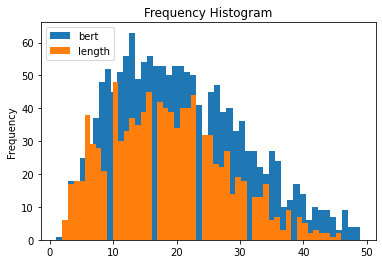

In [239]:
import itertools
x = list(itertools.chain.from_iterable(num_bert_peaks))
plt.hist(x, bins=50, label = "bert")
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
x = [len(i.split()) for i in train_sentences[:max_num]]
plt.hist(x, bins=50,  label ="length")
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
plt.legend(loc="upper left")

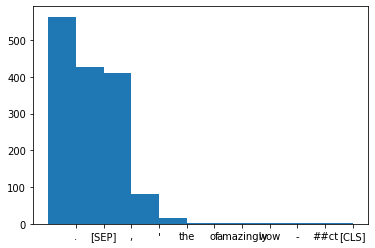

In [ ]:
from collections import Counter
peak_bert_words = Counter(peak_bert_words)
items = sorted(peak_bert_words.items(),key=lambda x: x[1],reverse=True)
labels, values = zip(*items)
indexes = np.arange(len(labels))
width = 1
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [ ]:
items[:5]

[('.', 564), ('[SEP]', 427), (',', 412), ("'", 82), ('the', 16)]

##### RoBERTa

[ 1 23]


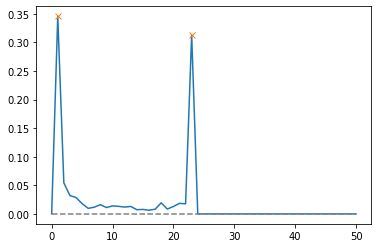

[ 1 18]


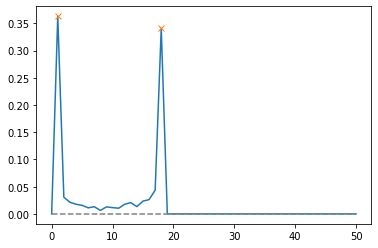

[ 1 45]


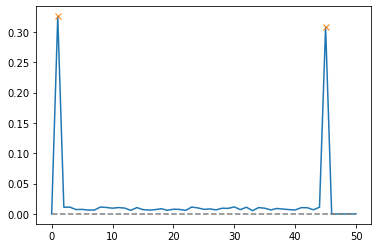

[ 1 14]


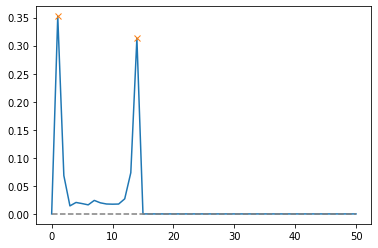

[ 1 23]


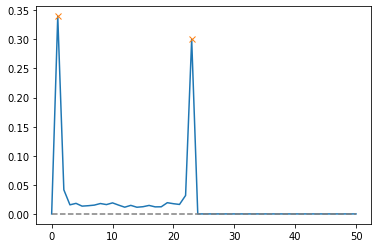

[1 7]


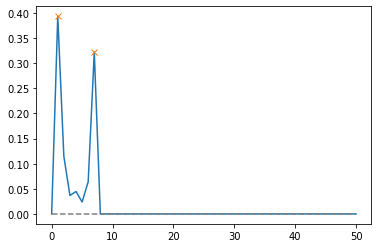

[ 1 32]


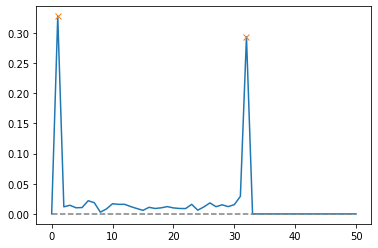

[ 1 23]


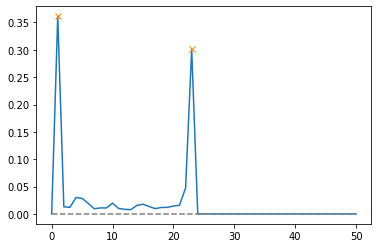

[ 1 21]


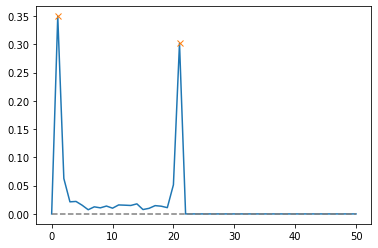

[ 1 21]


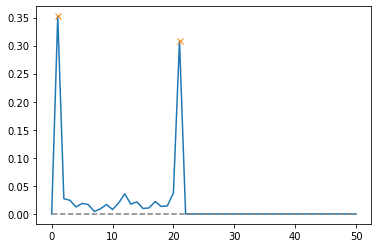

In [ ]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
for i in np.arange(10):
  x = np.mean(condensed_attention(i,robertaattentions),axis=0)
  x =np.insert(x,0,0)
  #electrocardiogram()[2000:4000]
  peaks, _ = find_peaks(x, prominence=0.1)
  plt.plot(x)
  print(peaks)
  plt.plot(peaks, x[peaks], "x")
  plt.plot(np.zeros_like(x), "--", color="gray")
  plt.show()

In [ ]:
num_roberta_peaks = []
peak_roberta_words = []
for sample_id in np.arange(max_num):
  x = np.mean(condensed_attention(sample_id,robertaattentions),axis=0)
  x = np.insert(x,0,0)
  #electrocardiogram()[2000:4000]
  peaks, _ = find_peaks(x, prominence=0.1)
  num_roberta_peaks.append(list(peaks))
  sentence = ["FILLER"]+robertatokenizer.convert_ids_to_tokens(robertainputs["input_ids"][sample_id])
  peak_roberta_words.extend([sentence[i] for i in peaks])

In [ ]:
print("On average each sentence has",np.mean([len(i) for i in num_roberta_peaks]),"peaks")

On average each sentence has 1.994 peaks


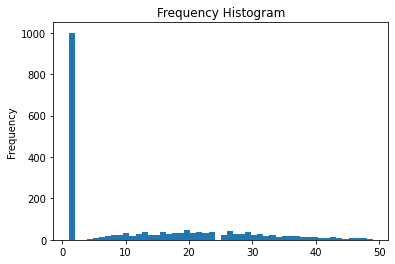

In [242]:
import itertools
x = list(itertools.chain.from_iterable(num_roberta_peaks))
plt.hist(x, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');


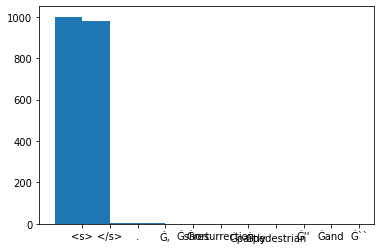

In [226]:
from collections import Counter
peak_roberta_words = Counter(peak_roberta_words)
items = sorted(peak_roberta_words.items(),key=lambda x: x[1],reverse=True)
labels, values = zip(*items)
indexes = np.arange(len(labels))
width = 1
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [227]:
items[:10]

[('<s>', 1000),
 ('</s>', 982),
 ('.', 3),
 ('Ġ,', 2),
 ('Ġshort', 1),
 ('Ġresurrection', 1),
 ('Ġpartly', 1),
 ('Ġpedestrian', 1),
 ("Ġ''", 1),
 ('Ġand', 1)]

##### DeBERTa

[22]


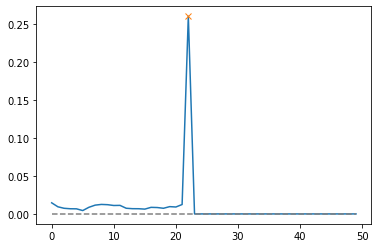

[17]


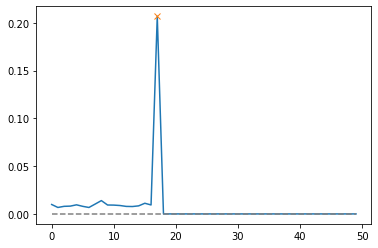

[44]


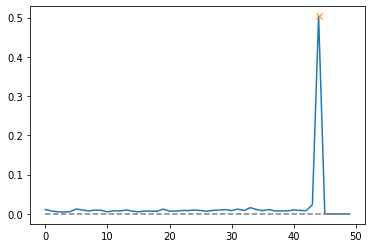

[13]


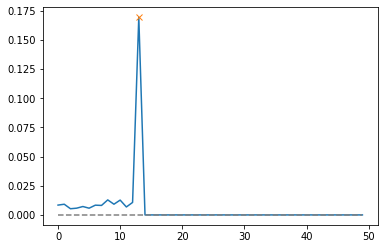

[22]


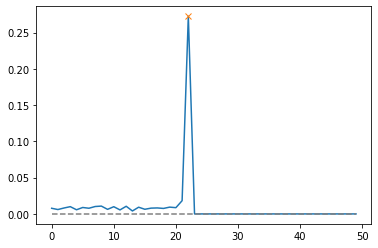

[]


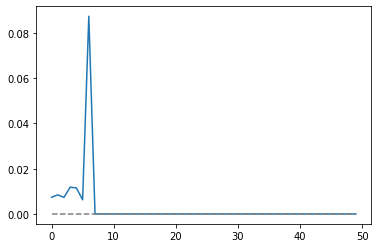

[31]


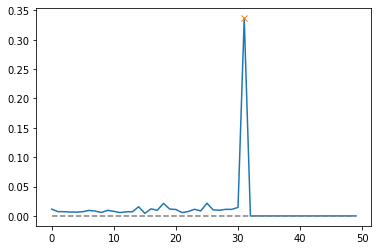

[22]


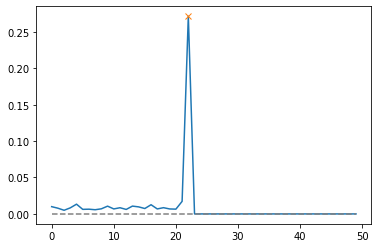

[20]


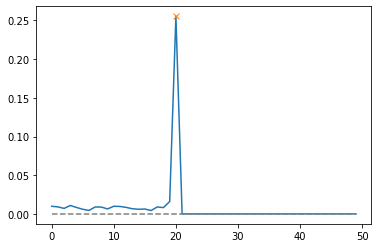

[20]


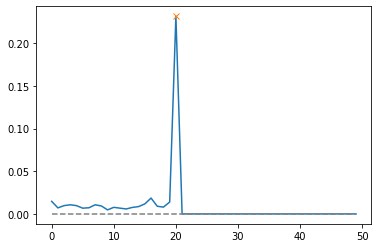

In [ ]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
for i in np.arange(10):
  x = np.mean(condensed_attention(i,debertaattentions),axis=0)
  #electrocardiogram()[2000:4000]
  peaks, _ = find_peaks(x, prominence=0.1)
  plt.plot(x)
  print(peaks)
  plt.plot(peaks, x[peaks], "x")
  plt.plot(np.zeros_like(x), "--", color="gray")
  plt.show()

In [ ]:
num_deberta_peaks = []
peak_deberta_words = []
for sample_id in np.arange(max_num):
  x = np.mean(condensed_attention(sample_id,debertaattentions),axis=0)
  x = np.insert(x,0,0)
  #electrocardiogram()[2000:4000]
  peaks, _ = find_peaks(x, prominence=0.1)
  num_deberta_peaks.append(list(peaks))
  sentence = ["FILLER"] + debertatokenizer.convert_ids_to_tokens(debertainputs["input_ids"][sample_id])
  peak_deberta_words.extend([sentence[i] for i in peaks])

In [228]:
print("On average each sentence has",np.mean([len(i) for i in num_deberta_peaks]),"peaks")

On average each sentence has 0.94 peaks


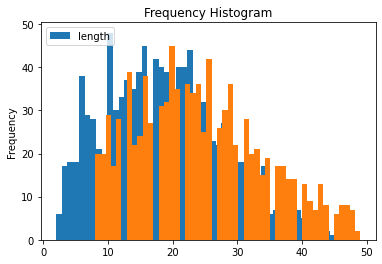

In [245]:
import itertools
x = [len(i.split()) for i in train_sentences[:max_num]]
plt.hist(x, bins=50,  label ="length")
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
plt.legend(loc="upper left")

x = list(itertools.chain.from_iterable(num_deberta_peaks))
plt.hist(x, bins=50, label="deberta")
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');


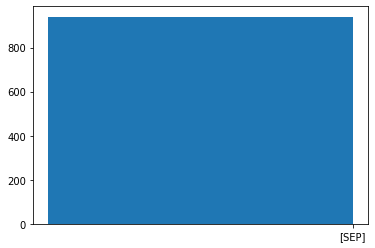

In [230]:
from collections import Counter
peak_deberta_words = Counter(peak_deberta_words)
items = sorted(peak_deberta_words.items(),key=lambda x: x[1],reverse=True)
labels, values = zip(*items)
indexes = np.arange(len(labels))
width = 1
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [231]:
items[:5]

[('[SEP]', 940)]

### Summary

Answers:

*   Does RoBERTa have strips any more than DeBERTa ?
* * Yeah, RoBERTa, BERT and DeBERTa have respectively 1.5, 1.99, 0.94
*   Are DeBERTa strips only in the [CLS] position ?
* * Nope, DeBERTa are almost always at the end, similar to BERT, but in fact RoBERTa attends to first token about half of the times 
*   Is the cause of RoBERTa strips due to function words ?
* * Nope, this is in fact BERT's behaviour

Bonus:
 
*  Is it desirable to have the strips only for the [CLS] token ?
* * While it is hard to show "desirability", DeBERTa makes lesser peaks and they are generally not at useful positions. Hard to see desirability of that


NOTE: We make lot of assumptions, while the authors might not have the same conditions for presenting the visualizations